<a href="https://colab.research.google.com/github/GPhMorin/geneo/blob/main/examples/kinship_umap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kinship computation and visualization

This script computes pairwise kinship coefficients of the probands from the **genea140** dataset and plots the individuals based on those coefficients.

In [1]:
!python --version

Python 3.10.12


Uniform Manifold Approximation and Projection (UMAP) will be used for dimensionality reduction, whereas Seaborn will be used for plotting. The GENEO toolkit will be used for loading the datasets, identifying the probands, and computing the pairwise kinship coefficients.

In [2]:
%pip install umap-learn seaborn https://github.com/GPhMorin/geneo/archive/main.zip

  Using cached https://github.com/GPhMorin/geneo/archive/main.zip
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


The GENEO toolkit makes extensive use of Pandas dataframes, in this case, for the pairwise kinship coefficients and for the **pop140** dataset.

In [3]:
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import geneo as gen

Two datasets will be used: the **genea140** dataset, which according to the [GENLIB reference manual](https://cran.r-project.org/web/packages/GENLIB/GENLIB.pdf) corresponds to:
> "A genealogical corpus made of 41523 individuals from the province of Quebec, Canada. A total of 140 individuals have been sampled in seven sub-populations, listed in pop140, and their genealogies were reconstructed as far back as possible using the BALSAC population register and the Early Quebec Population Register.

In [4]:
genea140 = gen.genealogy(gen.genea140)
genea140

A pedigree with:
41523 individuals;
68248 parent-child relations;
20773 men;
20750 women;
140 probands;
18 generations.

The other dataset is **pop140** and accompanies **genea140**. According to the GENLIB reference manual:
> The 140 individuals from the genealogical corpus from Quebec were sampled from 7 different populations from 5 regions; Quebec City, Montreal, Saguenay, North Shore, Gaspesia. In Gaspesia we find 3 different populations: French-Canadians, Acadians and Loyalists.

In [5]:
pop140 = pd.read_csv(gen.pop140, sep='\t')
pop140.iloc[:10, :]

,ind,pop
0,409682,Saguenay
1,409687,Saguenay
2,868387,Saguenay
3,717537,Saguenay
4,302711,Saguenay
5,302716,Saguenay
6,868572,Saguenay
7,717634,Saguenay
8,409808,Saguenay
9,718567,Saguenay


Now let's compute the pairwise kinship coefficients. On a recent computer, it should take just a few seconds to run the next line, especially if you have OpenMP detected during the toolkit's installation.

In [6]:
phi = gen.phi(genea140)
phi.iloc[:5, :5]

,217891,218089,219947,288708,288764
217891,0.501290,0.000235,0.005807,0.005166,0.008142
218089,0.000235,0.500118,0.000271,0.000230,0.000230
219947,0.005807,0.000271,0.502834,0.006361,0.007380
288708,0.005166,0.000230,0.006361,0.502508,0.008097
288764,0.008142,0.000230,0.007380,0.008097,0.506433


In another situation where the genealogies are bigger, you can run `gen.phi(genea140, compute=False)` to get information about the minimum RAM required.

In [7]:
gen.phi(genea140, compute=False)

You will require at least 2.84 GB of RAM.


`random_state=42` here is added only for reproducibility.

Instead of using the classical Euclidean distance, a modified version is used where the diagonal values are ignored.

In [8]:
def masked_euclidean_distance(similarity_matrix):
    mask = np.ones_like(similarity_matrix)
    np.fill_diagonal(mask, 0)
    masked_similarity = similarity_matrix * mask

    # Calculate pairwise distances using the masked similarity matrix
    distances = np.zeros_like(similarity_matrix)
    for i in range(len(similarity_matrix)):
        for j in range(i+1, len(similarity_matrix)):
            distances[i, j] = np.linalg.norm(masked_similarity[i] - masked_similarity[j])
            distances[j, i] = distances[i, j]

    return distances

In [9]:
dist = masked_euclidean_distance(phi.to_numpy())
dist[:5, :5]

array([[0.        , 0.03752359, 0.01455823, 0.01431498, 0.02072241],
       [0.03752359, 0.        , 0.03608825, 0.03686001, 0.04832204],
       [0.01455823, 0.03608825, 0.        , 0.00970407, 0.01690805],
       [0.01431498, 0.03686001, 0.00970407, 0.        , 0.01673784],
       [0.02072241, 0.04832204, 0.01690805, 0.01673784, 0.        ]])

In [10]:
emb = umap.UMAP(metric='precomputed', random_state=42).fit_transform(dist)
emb[:10, :]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


array([[ 4.6659517,  6.7136865],
       [-3.642768 ,  3.7981274],
       [ 5.058886 ,  6.9383855],
       [ 5.137341 ,  7.0348144],
       [ 6.1684546,  6.779021 ],
       [ 4.535365 ,  6.846026 ],
       [ 4.728431 ,  7.1909547],
       [ 5.9552903,  6.69119  ],
       [ 6.3749747,  6.7176814],
       [ 5.62895  ,  7.0894623]], dtype=float32)

Probands are identified using the `gen.pro` function.

In [11]:
pro = gen.pro(genea140)
pro[:10]

[217891,
 218089,
 219947,
 288708,
 288764,
 302710,
 302711,
 302716,
 302717,
 302718]

For each proband, we obtain their corresponding population from the **pop140** dataset.

In [12]:
pops = [pop140.loc[pop140['ind'] == ind, 'pop'].iloc[0] for ind in pro]
pops[:10]

['Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay']

Finally, let's see the results.

In [13]:
population_to_pop = {
    'Gaspesia-Acadian': 'ACA',
    'Gaspesia-FrenchCanadian': 'GFC',
    'Gaspesia-Loyalist': 'LOY',
    'Montreal': 'MON',
    'NorthShore': 'NS',
    'Quebec': 'QUE',
    'Saguenay': 'SAG'
}

In [14]:
pop_to_color = {
    'ACA': 'red',
    'GFC': 'purple',
    'LOY': 'lime',
    'MON': 'orange',
    'NS': 'cyan',
    'QUE': 'blue',
    'SAG': 'darkgreen',
}

In [15]:
colors = [pop_to_color[population_to_pop[pop]] for pop in pops]
colors[:10]

['darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen']

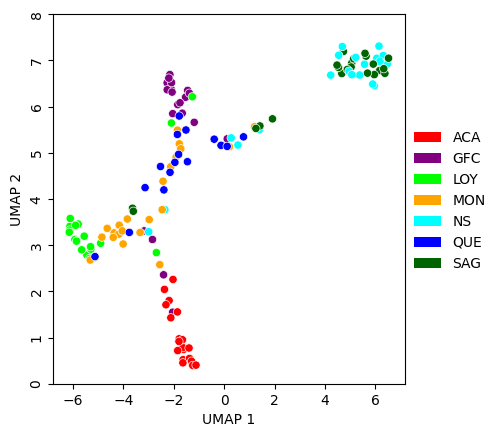

In [16]:
ax = sns.scatterplot(x=emb[:, 0], y=emb[:, 1], hue=colors,
                     palette={color: color for color in pop_to_color.values()})
ax.set_aspect((max(emb[:, 0]) - min(emb[:, 0])) /
              (max(emb[:, 1] - min(emb[:, 1]))))
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

# Get the current axis
x0, y0, w, h = ax.get_position().bounds

# Rotate the y axis labels
yticks = ax.get_yticks()
yticklabels = ax.get_yticklabels()
ax.set_yticks(yticks, yticklabels, va='center', rotation=90)


# Create a list of legend elements
legend_elements = [Patch(facecolor=color, label=pop)
                   for pop, color in pop_to_color.items()]

# Add the legend to the plot
ax.legend(handles=legend_elements, bbox_to_anchor=(x0 / 2 + w * 2, y0 + h / 2),
          loc='right', frameon=False)
plt.show()